In [1]:
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
import time
from skimage.feature import hog
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

In [2]:
# %load feat_extract.py
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [3]:
# %load slide_window.py
import numpy as np
import cv2
from feat_extract import *
import pickle


# Load parameters
dist_pickle = pickle.load( open("para_file.p", "rb" ) )
X_scaler = dist_pickle["scaler"] 
clf = dist_pickle["clf"] 
color_space = dist_pickle["color_space"] 
orient = dist_pickle["orient"] 
pix_per_cell = dist_pickle["pix_per_cell"] 
cell_per_block = dist_pickle["cell_per_block"] 
hog_channel = dist_pickle["hog_channel"] 
spatial_size = dist_pickle["spatial_size"] 
hist_bins = dist_pickle["hist_bins"] 
spatial_feat = dist_pickle["spatial_feat"] 
hist_feat = dist_pickle["hist_feat"] 
hog_feat = dist_pickle["hog_feat"] 


# # Read in a pickle file with bboxes saved
# # Each item in the "all_bboxes" list will contain a 
# # list of boxes for one of the images shown above
# box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

# # Read in image similar to one shown above 
# image = mpimg.imread('test_image.jpg')
# heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes


heat_buffer = deque([], 20)
def apply_threshold(heatmap, threshold, video=True):
    if video:
        global heat_buffer
        heat_buffer.append(heatmap)
        avg_heatmap = sum(heat_buffer)
        avg_heatmap[avg_heatmap <= threshold] = 0
        return avg_heatmap
    else:
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [7]:
# test_img = glob.glob('test_images/*.jpg')

# y_start_stop = [400, 656]
# for img in test_img:
#     image = mpimg.imread(img)
    
# #     image = cv2.imread(img)
    
# #     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     draw_image = np.copy(image)
    
#     image = image.astype(np.float32)/255



#     windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                         xy_window=(110, 110), xy_overlap=(0.75, 0.75))

#     hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
#                             spatial_size=spatial_size, hist_bins=hist_bins, 
#                             orient=orient, pix_per_cell=pix_per_cell, 
#                             cell_per_block=cell_per_block, 
#                             hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                             hist_feat=hist_feat, hog_feat=hog_feat)                       

#     window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    
#     heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
#     heat = add_heat(heat, hot_windows)
 
#     heat = apply_threshold(heat,2,False)

#     # Visualize the heatmap when displaying    
#     heatmap = np.clip(heat, 0, 255)

#     # Find final boxes from heatmap using label function
#     labels = label(heatmap)
#     draw_img = draw_labeled_bboxes(np.copy(image), labels)


#     plt.figure(figsize=(13,3))
    
#     plt.subplot(1,3,1)
#     plt.imshow(window_img)
    
#     plt.subplot(1,3,2)
#     plt.imshow(heatmap, cmap='hot')
    

#     plt.subplot(1,3,3)
#     plt.imshow(draw_img)
#     plt.show()

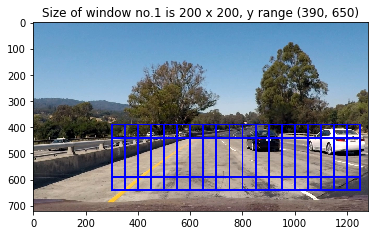

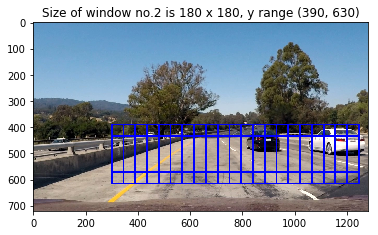

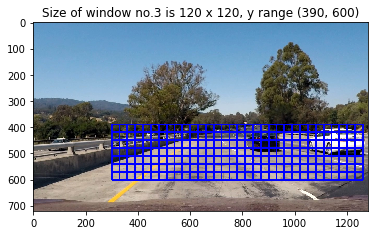

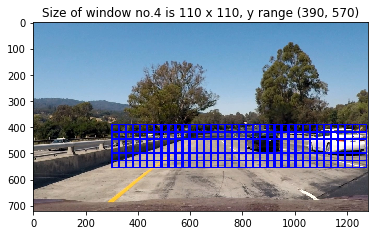

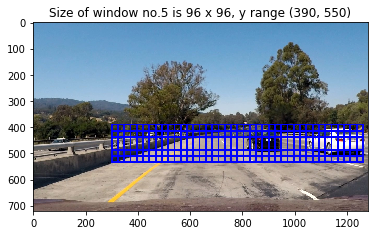

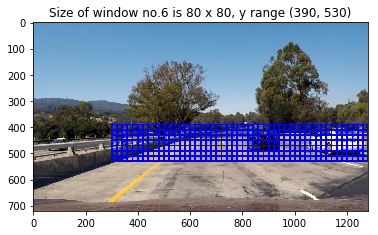

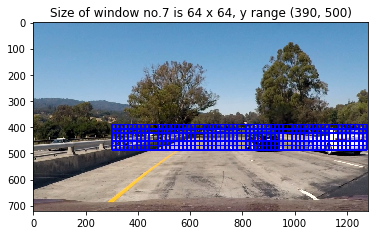

In [27]:
img = 'test_images/test1.jpg'

# image = cv2.imread(img)

# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


image = mpimg.imread(img)
draw_image = np.copy(image)
image = image.astype(np.float32)/255


all_y_start_stop = ([390, 650], [390, 630], [390, 600], [390, 570], [390, 550], [390, 530], [390, 500])
all_xy_window = [(200, 200), (180, 180), (120, 120),(110, 110), (96, 96), (80, 80), (64, 64)]

            

count = 0
for y_start_stop, xy_window in zip(all_y_start_stop, all_xy_window):
    count += 1
    windows = slide_window(image, x_start_stop=[300, None], y_start_stop=y_start_stop, 
                        xy_window=xy_window, xy_overlap=(0.75, 0.75))
    window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)   
    plt.imshow(window_img)
#     plt.axis('off')
    plt.title('Size of window no.{} is {} x {}, y range ({}, {})'.format(count, xy_window[0], xy_window[1], y_start_stop[0], y_start_stop[1]))
    plt.show()

In [9]:
def more_slide_window(image):
#     image = mpimg.imread(image)
    image = image.astype(np.float32)/255
    
    # # 1st try: too many false positive
    # #     y_start_stop = ([390, 650], [390, 630], [390, 600], [390, 550])
    # #     xy_window = [(200, 200), (180, 180), (120, 120), (70, 70)]

    # # 2nd: 
    #     y_start_stop = ([390, 650], [390, 600], [390, 500])
    #     xy_window = [(128, 128), (96, 96), (64, 64)]
    
#     y_start_stop = ([390, 650], [390, 600], [390, 600], [390, 500])
#     xy_window = [(128, 128), (110, 110), (96, 96), (64, 64)]
    
    windows1 = slide_window(image, x_start_stop=[300, None], y_start_stop=all_y_start_stop[0],
                        xy_window=all_xy_window[0], xy_overlap=(0.75, 0.75))
    windows2 = slide_window(image, x_start_stop=[300, None], y_start_stop=all_y_start_stop[1],
                        xy_window=all_xy_window[1], xy_overlap=(0.75, 0.75))
    windows3 = slide_window(image, x_start_stop=[400, None], y_start_stop=all_y_start_stop[2],
                        xy_window=all_xy_window[2], xy_overlap=(0.75, 0.75))
    windows4 = slide_window(image, x_start_stop=[300, None], y_start_stop=all_y_start_stop[3],
                        xy_window=all_xy_window[3], xy_overlap=(0.75, 0.75))
    
    windows5 = slide_window(image, x_start_stop=[300, None], y_start_stop=all_y_start_stop[4],
                        xy_window=all_xy_window[4], xy_overlap=(0.75, 0.75))
    
    windows6 = slide_window(image, x_start_stop=[300, None], y_start_stop=all_y_start_stop[5],
                        xy_window=all_xy_window[5], xy_overlap=(0.75, 0.75))
    
    windows7 = slide_window(image, x_start_stop=[300, None], y_start_stop=all_y_start_stop[6],
                        xy_window=all_xy_window[6], xy_overlap=(0.75, 0.75))
    
#     windows8 = slide_window(image, x_start_stop=[300, None], y_start_stop=all_y_start_stop[7],
#                         xy_window=all_xy_window[7], xy_overlap=(0.75, 0.75))
    
    windows = windows3 + windows4
    
    
    hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    return hot_windows

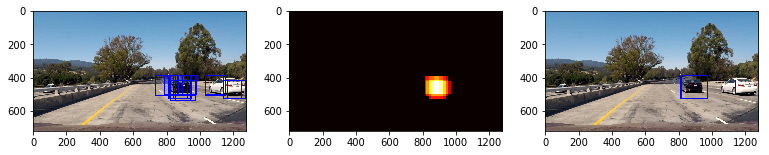

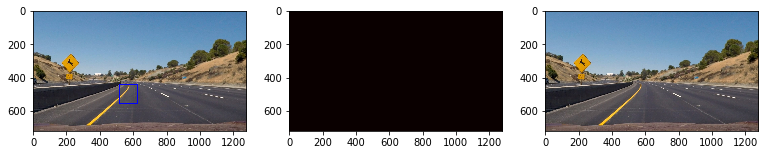

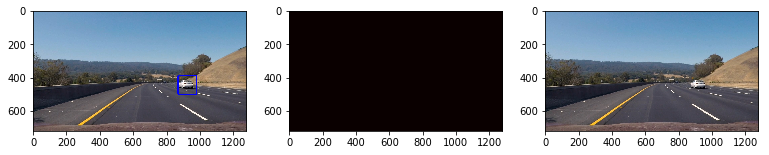

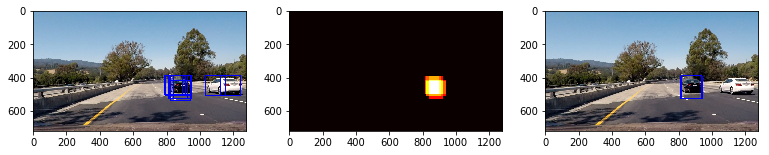

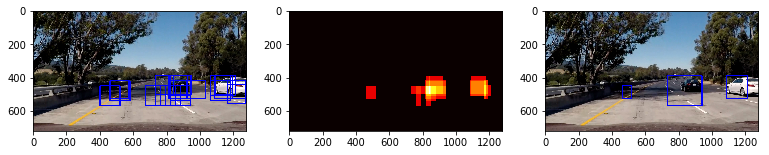

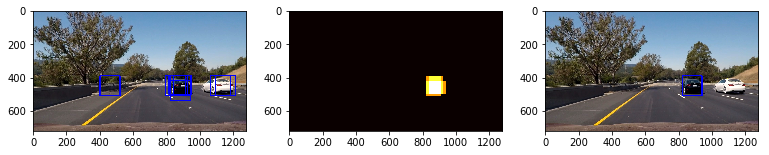

In [13]:
test_img = glob.glob('test_images/*.jpg')
for img in test_img:
#     img = cv2.imread(img)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = mpimg.imread(img)
    draw_image = np.copy(img)
    
    hot_windows = more_slide_window(img)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, hot_windows)
    heat = apply_threshold(heat,2, False)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_image, labels)

    plt.figure(figsize=(13,3))
    plt.subplot(1,3,1)
    plt.imshow(window_img)
    
    plt.subplot(1,3,2)
    plt.imshow(heatmap, cmap='hot')
    
    plt.subplot(1,3,3)
    plt.imshow(draw_img)
    plt.show()

In [11]:
def process_image(image):
#     image = image.astype(np.float32)/255
#     image = cv2.imread(image)
 
    draw_image = np.copy(image)
    
    
    hot_windows = more_slide_window(image)                 

                    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, hot_windows)
    heat = apply_threshold(heat,10)
    labels = label(heat)
    output_img = draw_labeled_bboxes(draw_image, labels)
    return output_img

In [12]:
video_input='test_video.mp4'
video_input='project_video.mp4'

# video_output='solution_win3_buffer30_time_36_42'+ video_input
# clip = VideoFileClip('{}'.format(video_input)).subclip(36, 42)


# video_output='solution_win3+4_buffer30_time_35_45'+ video_input
# clip = VideoFileClip('{}'.format(video_input)).subclip(35, 45)



video_output='solution_win3+4_buffer30_'+ video_input
clip = VideoFileClip('{}'.format(video_input))

out_clip = clip.fl_image(process_image) 
%time out_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video solution_win3+4_buffer30_project_video.mp4
[MoviePy] Writing video solution_win3+4_buffer30_project_video.mp4


100%|█████████▉| 1260/1261 [22:33<00:01,  1.06s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solution_win3+4_buffer30_project_video.mp4 

CPU times: user 21min 27s, sys: 44.2 s, total: 22min 12s
Wall time: 22min 35s
